In [1]:
# Import the libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# --- Data Loading (Corrected) ---
stock_symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-01-01'

# Download the data
df = yf.download(stock_symbol, start=start_date, end=end_date)

# A more robust check for data validity
if df.empty or 'Close' not in df.columns:
    print(f"No data found for symbol {stock_symbol}, or 'Close' column is missing.")
    print("Please check the stock symbol and your internet connection.")
    # You might want to stop execution here in a real script
    # For example: raise ValueError("Data download failed") 
else:
    print(f"Successfully downloaded {len(df)} data points.")
    
    # Create a new dataframe with only the 'Close' column
    # Using double brackets is a more standard way to select columns
    data = df[['Close']] 
    dataset = data.values # Convert to a numpy array

    # FIX: Reshape the data to be 2D
    dataset = dataset.reshape(-1, 1)

    # Get the number of rows to train the model on (80% of the data)
    training_data_len = int(np.ceil(len(dataset) * 0.8))
    print(f"Training data length: {training_data_len}")

C:\Users\ABISHEK\AppData\Local\Temp\ipykernel_444\22993675.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Successfully downloaded 2264 data points.
Training data length: 1812


In [6]:
# --- Data Scaling ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

print("Data scaled between 0 and 1.")

Data scaled between 0 and 1.


In [7]:
# --- Create Training Data ---
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into X_train and y_train
X_train = []
y_train = []
look_back_period = 60 # Number of past days to use for prediction

for i in range(look_back_period, len(train_data)):
    X_train.append(train_data[i-look_back_period:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data to be 3D for the LSTM model
# The LSTM model expects input in the format: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Shape of training data (X_train): {X_train.shape}")

Shape of training data (X_train): (1752, 60, 1)


In [8]:
# --- Build the LSTM Model ---
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layers
model.add(Dense(units=25))
model.add(Dense(units=1)) # Final output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Get a summary of the model's architecture
model.summary()

C:\Users\ABISHEK\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# --- Train the Model ---
print("Training the model... this may take a few minutes.")

# An epoch is one full pass through the entire training dataset.
# Batch size is the number of samples processed before the model is updated.
history = model.fit(X_train, y_train, batch_size=32, epochs=25)

print("Model training complete!")

Training the model... this may take a few minutes.
Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0091
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.6036e-04
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 9/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.5237e-04
Epoch 10/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.7011e-04
Epoch 11/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.9809e-04
Epoch 12/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6341e-04
Epoch 13/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6136e-04
Epoch 14/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.5

In [10]:
# --- Create Testing Data and Predict ---
# Create the testing data set from the scaled data
test_data = scaled_data[training_data_len - look_back_period:, :]

# Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len:, :] # The actual, un-scaled prices

for i in range(look_back_period, len(test_data)):
    X_test.append(test_data[i-look_back_period:i, 0])

# Convert the data to a numpy array
X_test = np.array(X_test)

# Reshape the data to be 3D for the model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# Get the model's predicted price values on the test data
predictions = model.predict(X_test)

# IMPORTANT: Un-scale the predicted values back to original dollar amounts
predictions = scaler.inverse_transform(predictions)

print("Predictions made on the test data.")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Predictions made on the test data.


C:\Users\ABISHEK\AppData\Local\Temp\ipykernel_444\3991580609.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


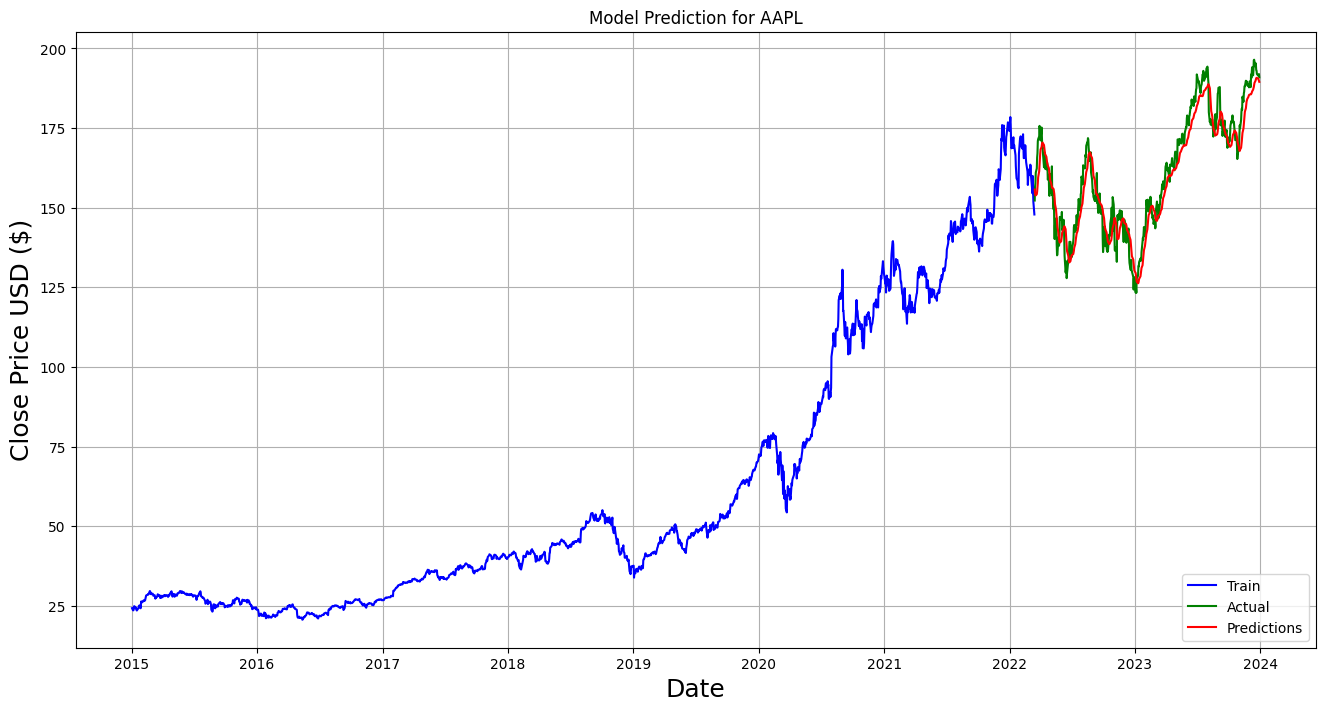


Last 10 Actual vs. Predicted Prices:
Price            Close Predictions
Ticker            AAPL            
Date                              
2023-12-15  195.911346  189.192780
2023-12-18  194.245453  189.839890
2023-12-19  195.286652  190.275162
2023-12-20  193.194351  190.634750
2023-12-21  193.045609  190.756363
2023-12-22  191.974686  190.722046
2023-12-26  191.429291  190.516403
2023-12-27  191.528458  190.187180
2023-12-28  191.954849  189.820679
2023-12-29  190.913651  189.494232


In [11]:
# --- Plot the Results ---
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title(f'Model Prediction for {stock_symbol}')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], color='blue')
plt.plot(valid['Close'], color='green')
plt.plot(valid['Predictions'], color='red')
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.grid(True)
plt.show()

# Display the last 10 actual vs. predicted prices
print("\nLast 10 Actual vs. Predicted Prices:")
print(valid[['Close', 'Predictions']].tail(10))